In [2]:
#Probably mass function - predicting class label via simple majority or plurality voting
#This is the ensemble error - this error is smaller than the error of the individual classifiers (0.034 vs 0.25)
#An assumption is that the errors are the same for all of the classifiers

from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) *
            error ** k *
            (1 - error) ** (n_classifier - k)
            for k in range(k_start, n_classifier + 1)]
    return sum(probs)
ensemble_error(n_classifier= 11, error= 0.25)

/Users/santiagocassalett/anaconda3/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/santiagocassalett/anaconda3/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


0.03432750701904297

In [ ]:
#Computing a range of ensemble error rates from 0.0 to 1.0

import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.0, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error = error)
             for error in error_range]

plt.plot(error_range, ens_errors,
        label = 'Ensemble error',
        linewidth = 2)
plt.plot(error_range, error_range,
        linestyle = '--', label = 'Base error',
        linewidth = 2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc = 'upper left')
plt.grid(alpha = 0.5)
plt.show()

#Ensemble is always better than individual classifiers as long as the base classifiers have an
# error that is better than random guessing (e < 0.5)

In [5]:
#Weighted majority vote - gives more weight to certain classifiers

import numpy as np
np.argmax(np.bincount([0, 0, 1],
                     weights = [0.2, 0.2, 0.6]))

1

In [10]:
#Weighted majority vote based on class probabilities instead of labels

ex = np.array([[0.9, 0.1],
             [0.8, 0.2],
             [0.4, 0.6]])

p = np.average(ex, axis = 0, weights = [0.2, 0.2, 0.6])
p
np.argmax(p)

0

In [44]:
#Combining all of the above - MajorityVoteClassifier
# Different than the book - got rid of "Six" which was only necessary for python 2.6 compatability

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator,
                            ClassifierMixin):
    """A majority vote classifier
    
    Parameters
    ----------
    classifiers: array-like, shape = [n_classifiers]
        Different classifiers for the ensemble
    
    vote: str, {'classlabel', 'probability'}
        Default: 'classlabel'
        If 'classlabel' the prediction is based on
        the argmax of class labels. Else if
        'probablity', the argmax of the sum of
        probabilities is used to predict the class label
        (recommended for calibrated classifiers).
        
    weights: array-like, shape = [n_classifiers]
        Optional, default: None
        If a list of `int` or `float` values are
        provided, the classifiers are weighted by
        importance; Uses uniform weights if `weights = None`
        
        """
    def __init__(self, classifiers,
                vote = 'classlabel', weights = None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for
                                 key, value in 
                                 _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        """ Fit Classifiers.
        
        Parameters
        ----------
        X: {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of training samples.
            
        y: array-like, shape = [n_samples]
            Vector of target class labels.
            
        Returns
        -------
        self:object
        
        """
        
        #Use LabelEncoder to ensure class labels start
        #with 0, which is important for np.argmax
        #call in self.predict
        
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                                       self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """Predict class labels for X.
        
        Parameters
        ----------
        
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
        
        """
        
        if self.vote == "probability":
            maj_vote = np.argmax(self.predict_proba(X),
                                axis = 1)
        
        else: # 'class label' vote
            
            #Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                     for clf in 
                                     self.classifiers_]).T
            
            maj_vote = np.apply_along_axis(
                        lambda x:
                        np.argmax(np.bincount(x,
                                             weights = self.weights)),
                        axis = 1,
                        arr = predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return(maj_vote)
    
    def predict_proba(self, X):
        """Predict class probabilities for X.
        
        Parameters
        ----------
        X: {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Training vectors, where n_samples is
            the number of samples and
            n_features is the number of features.
            
        Returns
        --------
        avg_proba: array-like,
            shape = [n_samples, n_classes]
            Weighted average probability for
            each class per sample.
        
        """
        probas = np.asarray([clf.predict_proba(X)
                            for clf in self.classifiers_])
        avg_proba = np.average(probas,
                              axis = 0, weights = self.weights)
        return avg_proba
    
    def get_params(self, deep = True):
        """Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier,
                        self).get_params(deep = False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep = True).items():
                    out['%s__%s' % (name, key)] = value
            return out

In [13]:
#Importing Iris dataset from sklearn - only going to pull out two variables to make classification
# more difficult and also only two classes

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

/Users/santiagocassalett/anaconda3/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [14]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                    test_size = 0.5,
                    random_state = 1,
                    stratify = y)

In [ ]:
#Now will train three different classifiers: Logistic regression classifier, Decision Tree,
# and K-nearest neighbors 
#Then evaluate the classifiers using 10-fold cross-validation before combining into
# the ensemble classifier:

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2',
                         C = 0.001,
                         random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                             criterion='entropy',
                             random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                           p=2, #Euclidean distance
                           metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                 ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                 ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree',
             'KNN']
print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator = clf,
                            X = X_train,
                            y = y_train,
                            cv = 10,
                            scoring = 'roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]'
         % (scores.mean(), scores.std(), label))

    
#Only logistic regression and KNN are trained with the pipeline because they need to be scaled/standardized
# and Decision Trees do not.

In [46]:
#Combining the individual classifiers into the ensemble

mv_clf = MajorityVoteClassifier(
                    classifiers= [pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv = 10,
                            scoring = 'roc_auc')
    print('Accuracy: %0.2f (+/- %0.2f) [%s]'
            % (scores.mean(), scores.std(), label))
    
#Accuracy of the ensemble is better than individual classifiers

Accuracy: 0.92 (+/- 0.15) [Logistic Regression]
Accuracy: 0.87 (+/- 0.18) [Decision Tree]
Accuracy: 0.85 (+/- 0.13) [KNN]
Accuracy: 0.98 (+/- 0.05) [Majority voting]


In [37]:
clf_labels

['Logistic Regression', 'Decision Tree', 'KNN', 'Majority voting']

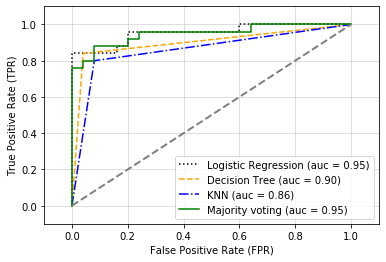

In [47]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, 
                                colors, linestyles):
    # assuming the label of the positive class is 1
    
    y_pred = clf.fit(X_train,
                    y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true = y_test,
                                    y_score = y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
            color = clr,
            linestyle = ls,
            label = '%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1],
            linestyle = '--',
            color = 'gray',
            linewidth = 2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha = 0.5)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

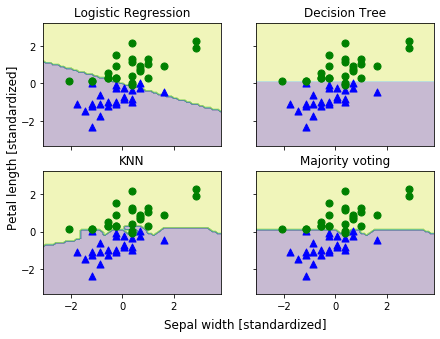

In [51]:
#Plotting the decision boundary

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 2, ncols = 2,
                       sharex='col',
                       sharey='row',
                       figsize = (7, 5))

for idx, clf, tt in zip(product([0,1], [0,1]),
                       all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                 X_train_std[y_train == 0, 1],
                                 c = 'blue',
                                 marker = '^',
                                 s = 50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0],
                                 X_train_std[y_train == 1, 1],
                                 c = 'green',
                                 marker = 'o',
                                 s = 50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.0,
        s = 'Sepal width [standardized]',
        ha = 'center', va = 'center', fontsize = 12)
plt.text(-12.5, 4.5,
        s = 'Petal length [standardized]',
        ha = 'center', va = 'center', fontsize = 12,
        rotation = 90)
plt.show()

In [52]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
          steps=[('sc',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ['clf',
                  LogisticRegression(C=0.001, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=1,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False)]],
          verbose=False),
 'decisiontreeclassifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split

In [57]:
# Tuning individual classifier's parameters using grid search
# tuning the C of the logisitic regression and depth of the decision tree
#Different than the book - GridSearchCV no longer has grid_scores_

from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
         'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                   param_grid=params,
                   cv = 10,
                   scoring='roc_auc')

grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))


0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [60]:
print('Best parameters: %s' %grid.best_params_)
print('Accuracy: %.2f' %grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
Accuracy: 0.98


In [1]:
#Bagging - only considering wine classes 2 and 3 and two features: alcohol and OD280

import pandas as pd
df_wine = pd.read_csv("wine.data")

In [3]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid',
                  'Ash', 'Alcalinity of ash', 'Magnesium', 
                  'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
                  'Proanthocyanins', 'Color intensity', 'Hue',
                  'OD280/OD315 of diluted wines', 'Proline']

#Drop 1 class

df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = \
            train_test_split(X, y, 
                            test_size = 0.2,
                            random_state = 1,
                            stratify = y)

In [8]:
#Bagging 500 trees on different bootstrapped samples
#Both of these (tree and bag) are initializations of the classifier and not actually
# fit to any data yet

from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion = 'entropy',
                             random_state=1,
                             max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                       n_estimators=500,
                       max_samples=1.0,
                       max_features = 1.0,
                       bootstrap = True,
                       bootstrap_features = False,
                       n_jobs = 1,
                       random_state = 1)

In [9]:
#Fitting the classifiers - calculating the accuracy scores for the 
# test and training datasets on the single tree (tree) or the ensemble (bag)

from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision tree train/test accuracy %.3f/%.3f'
         %(tree_train, tree_test))

#Results suggest that the single tree had a train accuracy of 100 but only 83 for test accuracy
# this suggests overfitting (high variance)

Decision tree train/test accuracy 1.000/0.833


In [10]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

print('Bagging train/test accuracy %.3f/%.3f'
         %(bag_train, bag_test))

#Slightly better generalization performance (test set) but same 100% training accuracy
# bagging is therefore slightly better (less overfit)

Bagging train/test accuracy 1.000/0.917


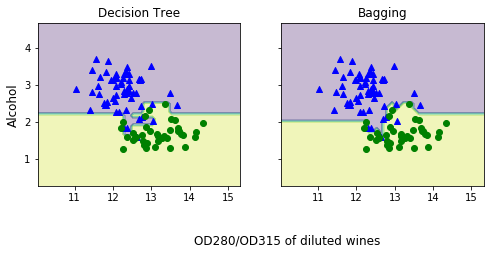

In [13]:
#Decision region for the two classifiers

x_min = X_train[:, 0].min()-1
x_max = X_train[:, 0].max()+1
y_min = X_train[:, 1].min()-1
y_max = X_train[:, 1].max()+1
xx,yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                   np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows = 1, ncols = 2,
                       sharex = 'col',
                       sharey = 'row',
                       figsize = (8, 3))

for idx, clf, tt in zip([0, 1],
                       [tree, bag],
                       ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                      X_train[y_train == 0, 1],
                      c = 'blue', marker = '^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                      X_train[y_train == 1, 1],
                      c = 'green', marker = 'o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize = 12)
plt.text(10.2, -1.2,
        s = 'OD280/OD315 of diluted wines',
        ha = 'center', va = 'center', fontsize = 12)
plt.show()
    


In [15]:
#Using AdaBoost - ensemble of multiple trees - different than bagging above
# all start with equal weights but misclassified samples are upweighted and 
# correctly classified samples are downweighted - final trees are then 
# combined and majority vote is done for the classifications

from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                             random_state=1,
                             max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree,
                        n_estimators=500,
                        learning_rate=0.1,
                        random_state=1)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision tree train/test accuracies %.3f/%.3f' 
         % (tree_train, tree_test))

#Underfits the training data - decision tree stump because max depth of 1
# versus the last was unprunned

#Adaboost gives very similar results to the bagging example above

Decision tree train/test accuracies 0.916/0.875


In [16]:
ada = ada.fit(X_train, y_train)

y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print('Adaboost train/test accuracies %.3f/%.3f' 
         % (ada_train, ada_test))

#We perfectly fit the training data but we increased the variance between the training data
# and the test data suggesting we are overfitting but decreases bias 

Adaboost train/test accuracies 1.000/0.917


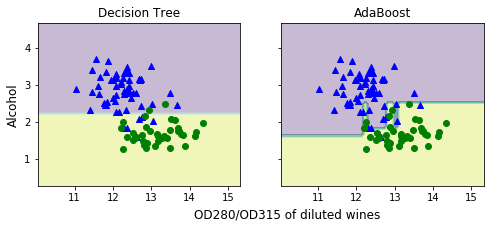

In [19]:
#Decision region for the two classifiers

x_min = X_train[:, 0].min()-1
x_max = X_train[:, 0].max()+1
y_min = X_train[:, 1].min()-1
y_max = X_train[:, 1].max()+1
xx,yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                   np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows = 1, ncols = 2,
                       sharex = 'col',
                       sharey = 'row',
                       figsize = (8, 3))

for idx, clf, tt in zip([0, 1],
                       [tree, ada],
                       ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                      X_train[y_train == 0, 1],
                      c = 'blue', marker = '^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                      X_train[y_train == 1, 1],
                      c = 'green', marker = 'o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize = 12)
plt.text(10.2, -0.5,
        s = 'OD280/OD315 of diluted wines',
        ha = 'center', va = 'center', fontsize = 12)
plt.show()
    
